<center>
    <h3>University of Toronto</h3>
    <h3>Department of Mechanical and Industrial Engineering</h3>
    <h3>MIE465 Analytics in Action </h3>
    <h3>(Winter 2019)</h3>
    <hr>
    <h1>Lab 6: Model Engineering</h1>
    <h3>February 27, 2019</h3>
</center>



# Introduction

So far, we have implemented several different models and conceptually discussed when one is more appropriate than the other. Sometimes in practice however, there are no clear guidelines on how to develop the best model for an application. Suppose we want to predict a binary classifier with high accuracy or some other metric. We are given a base dataset that when plugging into an off-the-shelf classifier, does not perform very well on the given metric. How do we proceed? 

- If we believe the features are not useful, we can use feature engineering methods to construct better, more relevant features.
- If we believe the model parameters are not appropriate, we can use cross-validation and search to tune the parameters.
- If we believe the model itself is not appropriate, we can search for better models.
- If we find a set of models that perform differently, we can combine them using ensembles, boosting, and stacking.

These are just a set of possible ways to improve our models. There are many ways to engineer better models, and often the practice of model engineering comes down to the application and our prior experience. In this lab, we will cover a few tricks that we can use: feature engineering, grid search, and stacking.


## Feature Engineering

Suppose we have a dataset where the features do not correlate well with the target. The first thing to always ask is whether we can collect more or better data. Sometimes this is not available and we must do the best with what we have. One option is then to create new, strong features that do correlate with the target by transforming and combining weak features. This practice is known as feature engineering.

Generally, good features have several desirable characteristics: (a) they are spread out evenly (e.g., Gaussian or uniform distributions), (b) they behave differently (e.g., they may have different means) when the target is different, (c) they are normalized to similar scales.

For example, you may have seen in the past that we take the logarithm or square root of a feature such as population or income. Usually these features encompass very large values and take on a Poisson-type distribution with a long tail. The problem with large values and long tails is that the absolute change in the value of a feature gives less information than the relative change. That is, a 100 dollar difference in income means very different things if you are comparing two low income data points versus two high income data points.

Another aspect of feature engineering is that different features alone provide some value, but they can often combine to form even more useful features. In statistics, this is known as an interaction effect, where the interaction is greater than the sum of the parts. For example, if two features correlate strongly with a target, it is likely that the product of the two features will also correlate. 

Constructing good features requires experience, domain expertise, and some luck. In your application, you should always think about whether a transformation or a new feature makes sense for the problem, and you should always check the correlation of a transformed or new feature with the target to validate your hypothesis. You can generally do anything to create new features. The common tricks include multiplying and dividing several existing features or applying monotonic transforms. However, there are two major rules with regards to feature engineering:

1. You should not create too many features, especially in order to chase marginal increases in correlation. If the correlation is small and your dataset is small, you might be creating fake (dataset-dependent) correlations that wont generalize outside of your data.
2. You **cannot** use the target variable to create a feature.


## Grid search

Many of the machine learning models that we use have a wide variety of parameters. For example, logistic regression on scikit-learn allows 'l1' or 'l2' regularization, a regularization weight 'C', and additional modifications to the loss function. Decision trees have parameters for depth, loss function, and splitting rules that [you can read about in the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 

When we are tuning a single parameter, the common method is to use k-fold cross-validation and evaluate for which setting does the model perform the best. However, how do we tune 5 or 6 different parameters all at once? The standard method is known as grid-searching, where we simply do k-fold cross-validation on all possible combinations of the different parameter values. In grid searching, the practice is to define a specific loss function, perform a search, and identify an appropriate model. Of course, this approach is computationally expensive, especially when there are a large number of parameters or values to consider. Interestingly, researchers have found that randomly searching the parameter space is often just as effective as grid searaching. What this suggests is that there is often no good intuitive way to construct features.

Grid searching is not limited to model parameters but also to models themselves! For example, if you do not know whether a logistic regression or a decision tree is a better model, your best bet is to just try both and see what works.


## Ensembles and stacking

The principle of random forests is that rather than constructing one very optimized decision tree, we can construct a family of simple decision trees. Random forests and other ensemble methods work on the assumption that on average, most of the trees will predict well, and so it is sufficient to just vote on predictions.

Stacking models operate on a similar basis, but rather than simply using a voting rule to obtain a prediction, we use another prediction model. In a stacking model, we train a series of *different* prediction models on the dataset. The predicted targets that each of these simple models provide are used as additional engineered features for another machine learning model. The principle is that the initial models will be able to do most of the work learning from the data. However, the final model will be able to use those results, categorize, and learn when one predictive model is appropriate over another.


# Application
In the lending industry, investors provide loans to borrowers in exchange for the promise of repayment with interest. If the borrower repays the loan, then the lender profits from the interest. However, sometimes the borrower is unable to repay the loan, meaning the lender loses money. The lender in this problem wants to be able to predict when a borrower is unlikely to be able to repay a loan and has asked us to build the best possible predictor.

First, let us import the essential tools.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

## Loading and exploring the data
Load the dataset and store it in a variable ```df_raw```.

In [2]:
df_raw = pd.read_csv('LoansRevised.csv')
df_raw.head()

,CreditPolicy,Purpose,IntRate,Installment,Dti,Fico,DaysWithCrLine,RevolBal,RevolUtil,InqLast6mths,Delinq2yrs,PubRec,NotFullyPaid,AnnualInc
0,1,debt_consolidation,0.1189,829.10,19.48,737,5639.958333,28854,52.1,0,0,0,0,85000.000385
1,1,credit_card,0.1071,228.22,14.29,707,2760.000000,33623,76.7,0,0,0,0,65000.000073
2,1,debt_consolidation,0.1357,366.86,11.63,682,4710.000000,3511,25.6,1,0,0,0,31999.999943
3,1,debt_consolidation,0.1008,162.34,8.10,712,2699.958333,33667,73.2,1,0,0,0,85000.000385
4,1,credit_card,0.1426,102.92,14.97,667,4066.000000,4740,39.5,0,1,0,0,80799.999636


The dataset should not contain any missing data, but you can double-check if you want. The table below contains the data dictionary. The target is ```NotFullyPaid```.

|Feature         |Definition                               |
|:--------------:|:----------------------------------------|
|CreditPolicy    |1 if the borrower meets the underwriting criteria                       |
|Purpose         |Written purpose of the loan                           |    
|IntRate         |Assigned interest rate                           |
|Installment     |Monthly installments                      |  
|Dti             |Borrower's debt to income ratio               |
|Fico            |Borrower's FICO (credit) score                    |
|DaysWithCrLine  |Number of days the borrower has had an existing line of credit                 |
|RevolBal        |Revolving balance (current unpaid credit-card debt)            |
|RevolUtil       |Revolving line utilization (fraction of line of credit used)                 |
|InqLast5mths    |Number of inquiries by creditors in last 5 months            |
|Delinq2yrs      |Number of times the borrower has been 30+days past due in last 2 years                         |
|PubReq          |Number of derogatory public records                    |
|NotFullyPaid    |1 if the loan was not fully paid back                       |
|AnnualInc       |Self-reported annual income of borrower         |


The Purpose column is categorical, so let's encode the information into a series of binary variables.

In [3]:
unique_types = df_raw.Purpose.unique()
for unique in unique_types:
    df_raw[unique] = df_raw.Purpose.apply(lambda x: 1 if x == unique else 0)
df = df_raw.drop(columns=['Purpose'])
df.head()

,CreditPolicy,IntRate,Installment,Dti,Fico,DaysWithCrLine,RevolBal,RevolUtil,InqLast6mths,Delinq2yrs,PubRec,NotFullyPaid,AnnualInc,debt_consolidation,credit_card,all_other,home_improvement,small_business,major_purchase,educational
0,1,0.1189,829.10,19.48,737,5639.958333,28854,52.1,0,0,0,0,85000.000385,1,0,0,0,0,0,0
1,1,0.1071,228.22,14.29,707,2760.000000,33623,76.7,0,0,0,0,65000.000073,0,1,0,0,0,0,0
2,1,0.1357,366.86,11.63,682,4710.000000,3511,25.6,1,0,0,0,31999.999943,1,0,0,0,0,0,0
3,1,0.1008,162.34,8.10,712,2699.958333,33667,73.2,1,0,0,0,85000.000385,1,0,0,0,0,0,0
4,1,0.1426,102.92,14.97,667,4066.000000,4740,39.5,0,1,0,0,80799.999636,0,1,0,0,0,0,0


We will play around with a lot of different models in this lab. In order to experiment fairly, it is imperative that we split the data into a training and validation set.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.drop(columns=['NotFullyPaid']),
                                                    df.NotFullyPaid,
                                                    test_size = 0.2,
                                                    random_state = 1)

We can analyze ```X_train, X_val, y_train, y_val``` as much as we want when designing or optimizing a model. However, let's save the test set for the end.

Let's start with some exploratory analysis. We can use the ```describe()``` method on a dataframe to quickly print out a summary of the columns. Take a quick scan through the data. Use the ```corr()``` method and anything else you want to explore as well. Try to answer the following questions.

1. How often do borrowers default on their loans?
2. Which of the purposes for borrowing is most likely to lead to a default?
3. Which of the purposes has the highest correlation with the ```NotFullyPaid``` variable?
4. Are there any imbalanced features?


1. There are 1210 defaults over 7662 loans
2. debt_consolidation is most likely to lead to a default
3. IntRate has the highest correlation with the NotFullyPaid variable


<Figure size 432x288 with 0 Axes>

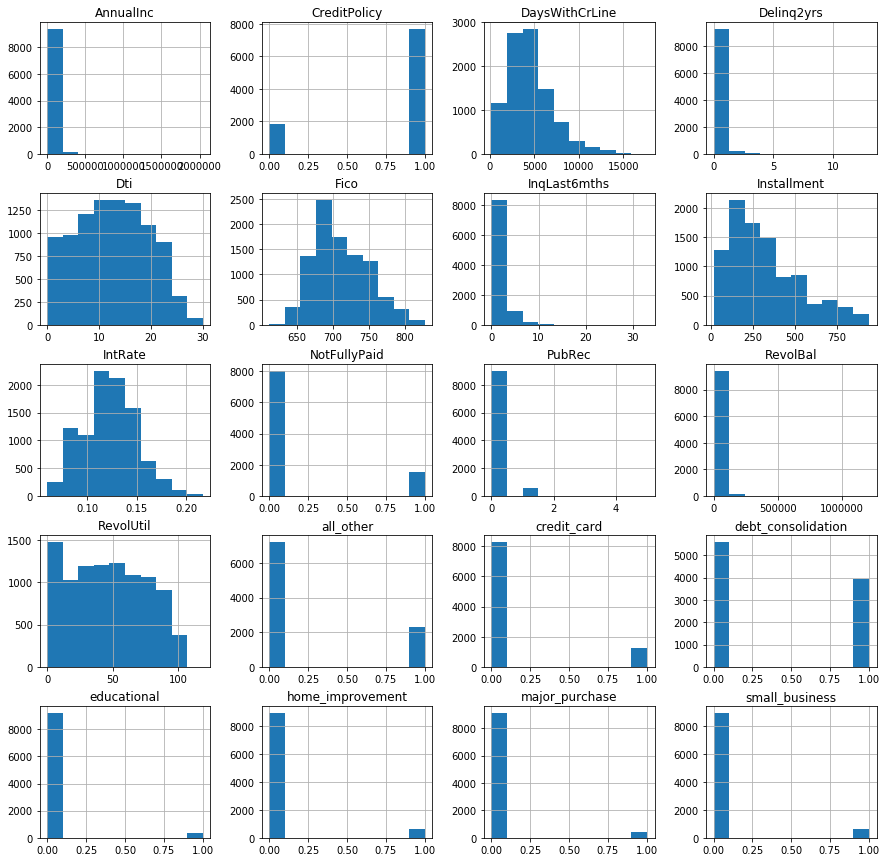

In [38]:
# Answer the questions here
# 1
print('1. There are {} defaults over {} loans'.format(y_train.sum(), y_train.shape[0]))

# 2
print('2. {} is most likely to lead to a default'.format(df_raw[df_raw['NotFullyPaid'] == 1]['Purpose'].value_counts().index[0]))

# 3
print('3. {} has the highest correlation with the NotFullyPaid variable'.format(df.corr().loc['NotFullyPaid'].abs().sort_values(ascending = False).index[1]))

# 4 
plt.figure()
df.hist(figsize = (15,15))
plt.show()

For starters, we can fit a simple logistic regression model and call it ```baseline```. We will evaluate all models on the precision and the recall (i.e., TPR). Write a function that takes a model, fits it on a training dataset,  evaluates precision and recall on the validation set, and outputs these two evaluation metrics. You can use the ```precision_score()``` and ```recall_score()``` functions below to calculate those metrics.

In [44]:
from sklearn.metrics import precision_score, recall_score

baseline = LogisticRegression(random_state=1)

def fit_and_score_model(mdl, X_train, X_val, y_train, y_val):
    # Write some code to fit the model, and calculate precision and recall on
    # the validation set.
    baseline.fit(X_train, y_train)
    y_pre = baseline.predict(X_val)
    pre = precision_score(y_val, y_pre)
    rec = recall_score(y_val, y_pre)
    
    # -------------------------------------------------------------------------
    print('On the validation set, the precision is {} and recall is {}'.format(pre, rec))
    return pre, rec
    
precision, recall = fit_and_score_model(baseline, X_train, X_val, y_train, y_val)


On the validation set, the precision is 0.0 and recall is 0.0


C:\Users\Kevin Zhang\AppData\Local\conda\conda\envs\Keras\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Kevin Zhang\AppData\Local\conda\conda\envs\Keras\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1. What is the logistic regression model doing?
2. Why should we use precision and recall as our metrics for this problem rather than the usual ROC metrics?

1. it's predicting everything as 0


Clearly, a baseline logistic regression model is not a good idea. Let's use a decision tree instead as our baseline.


In [45]:
baseline = DecisionTreeClassifier(random_state=1)

precision, recall = fit_and_score_model(baseline, X_train, X_val, y_train, y_val)

# We should also save the model.
all_models = {}
all_models['baseline'] = (precision, recall, baseline, 'runs on X_train')

On the validation set, the precision is 0.24624624624624625 and recall is 0.25386996904024767


Notice that in the above code, we have created a dictionary ```all_models```, where we saved the precision, recall, and the model itself as a tuple. As we go along, we will update this dictionary. At the end of this lab, we will run all of the models in this dictionary on the testing set to see how they differ.

The precision and recall on the validation set is the baseline score. Our job from here on is to develop the best possible classifier to improve both metrics. We will build and train our models on the training set and evaluate on the validation set.

## Transforming your data to get better predictors

Let's start by applying some simple transforms on the variables. First we should identify which variables to work with. Go through ```X_train``` and for each of the features that are continuous variables, plot a histogram of that variable for all ```y_train == 1``` and for all ```y_train == 0```. Remember that you can use ```.hist(<column name>)``` to quickly plot histograms.

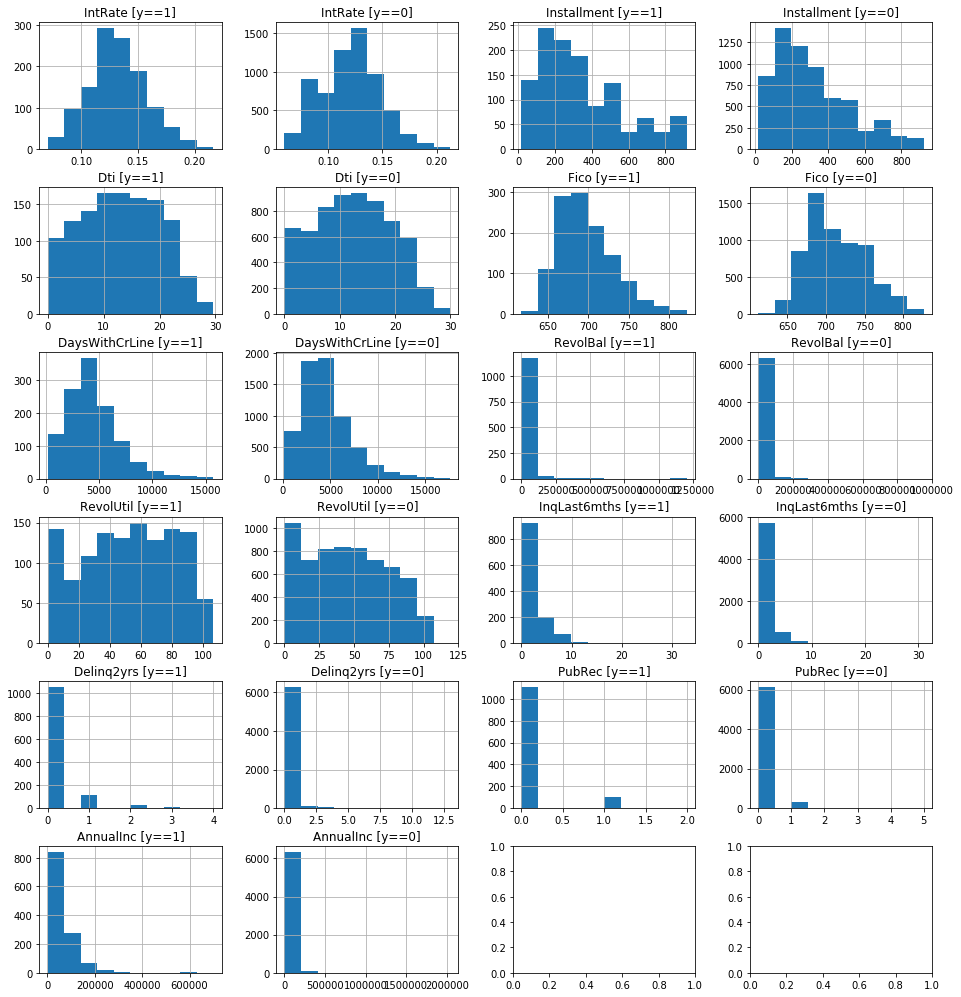

In [46]:
continuous_variables = ['IntRate', 'Installment', 'Dti', 'Fico', 'DaysWithCrLine', 
                        'RevolBal', 'RevolUtil', 'InqLast6mths', 'Delinq2yrs', 
                        'PubRec', 'AnnualInc']

fig, ax = plt.subplots(6,4, figsize=(16, 12))
fig.subplots_adjust(bottom=0.4, top=1.5)
ax = ax.ravel()

for i, col in enumerate(continuous_variables):
    # Plot the feature when y is 1
    X_train[y_train == 1].hist(col, ax=ax[2*i])
    ax[2*i].set_title('{} [y==1]'.format(col))
    
    # Plot the feature when y is 0
    X_train[y_train == 0].hist(col, ax=ax[2*i+1])
    ax[2*i+1].set_title('{} [y==0]'.format(col))


Going through your data, you should notice that several of the variables behave in a Poisson distribution with a very long tail. The problem with these distributions is that the relative change in the feature variable is a bigger indicator of the effect on the target rather than the absolute change. You commonly see this behaviour with money or population features. For example, a 100 dollar difference in annual income means very different things if you are comparing two low income data points versus two high income data points.

In such cases, its useful to apply a log or a square-root transform on the feature. What these transforms do is try to spread the low-value data over a larger range. A common rule of thumb is that when your variables have low-values that are greater than 10000, to use a log transform, and if less, then to use a square-root transform.

Below, we've provided some code to make a copy of ```X_train``` and apply a log transform to the AnnualInc and RevolBal variables and a square root transform to Installment and Fico. Plot histograms of the new features like you did before with ```y_train == 1``` and ```y_train == 0```. What do you observe about the new features?


In [47]:
# First we copy the data and then apply some transforms.
X_new = X_train.copy()

X_new['LogAnnualInc'] = np.log(X_new['AnnualInc'])
X_new['LogRevolBal'] = np.log(X_new['RevolBal']+1)
X_new['SqrtInstallment'] = np.sqrt(X_new['Installment'])
X_new['SqrtFico'] = np.sqrt(X_new['Fico'])
    

    
# Write some code to plot the new features and compare with the old ones.

    
# -------------------------------------------------------------------------

Your new features should look like this:
![new_features](img/new_features.png)

Let's try and develop a new logistic regression model with these transformed features. We want to make sure that this is done in a repeatable way. We can write a function that makes a copy of a dataframe and applies the transforms. Then, we use the function on ```X_train``` and ```X_val``` to generate a new dataset that includes the transformed features, which we then use to train a decision tree.

**Note that we will always copy the dataframe to a new variable rather than directly editing ```X_train```. This is slightly inefficient, but will ensure that we don't have to re-load the dataset whenever we are exploring.**

In [48]:
def monotone_transform(X):
    X_new = X.copy()
    X_new['LogAnnualInc'] = np.log(X_new['AnnualInc'])
    X_new['LogRevolBal'] = np.log(X_new['RevolBal']+1)
    X_new['SqrtInstallment'] = np.sqrt(X_new['Installment'])
    X_new['SqrtFico'] = np.sqrt(X_new['Fico'])
    
    return X_new

X_train_monotone = monotone_transform(X_train)
X_val_monotone = monotone_transform(X_val)
mdl_monotone = DecisionTreeClassifier(random_state=1)

precision, recall = fit_and_score_model(mdl_monotone, 
                                        X_train_monotone, 
                                        X_val_monotone, 
                                        y_train, 
                                        y_val)

# We should also save the model.
all_models['monotone'] = (precision, recall, mdl_monotone, 'run monotone_transform()')

On the validation set, the precision is 0.27388535031847133 and recall is 0.26625386996904027


Note that once again, we save the model inside ```all_models```.

You should see a slight improvement in the model precision, but unfortunately, it didn't seem to do much for this case. 

Another method of constructing new features is to find interaction effects from combining two or more features. The best way to go about this is by domain knowledge and developed intuition. One trick is to look at features that are already good predictors and see if they can combine to become even better. For example, you may have noticed earlier that credit policy and FICO score both strongly negatively correlate with the target. The simplest thing to try is to just multiply or divide the two features and construct a new feature ```credit_policy * fico```.

Of course, if you don't have the domain knowledge, another way to go about it is just try combinations of multiple features to see if you can combine them to construct a new feature with higher correlation to the target than the originals. We've provided some code below that loops through every pair of features, and applies a transformation (e.g., multiplication, division). If the new feature has a correlation higher than the correlations of the original features, the code will print it out for us to inspect. Note that we add a ```+0.02``` to the requirement to make sure that the improvement is actually significant. If we didn't have that, then it would print out a lot of features that are likely to be useless! 

In [50]:
base_corrs = df.corr().NotFullyPaid.drop(index='NotFullyPaid')

for feature1 in base_corrs.index:
    for feature2 in base_corrs.index:
        if feature2 != feature1:
            # multiply the two features to create a new feature
            new_feature = X_train[feature1] / X_train[feature2]
            new_corr = np.abs(np.round(np.corrcoef(new_feature, y_train)[0,1], 3))
            corr1 = np.abs(np.round(base_corrs[feature1], 3))
            corr2 = np.abs(np.round(base_corrs[feature2], 3))
            
            # add a threshold of 0.02 to make sure that the improvement is meaningful
            if new_corr > max(corr1, corr2)+0.02:
                print('{} {} combine to get correlation {} compared to {} {}'.format(
                    feature1, feature2, new_corr, corr1, corr2))

CreditPolicy IntRate combine to get correlation 0.194 compared to 0.158 0.16
Installment AnnualInc combine to get correlation 0.071 compared to 0.05 0.007
all_other AnnualInc combine to get correlation 0.04 compared to 0.009 0.007


C:\Users\Kevin Zhang\AppData\Local\conda\conda\envs\Keras\lib\site-packages\numpy\lib\function_base.py:2320: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


Play around with the above code and the space below to see if you can find any new interesting or useful features. For example, you could try different transforms of the features, or combining three features together. Oftentimes, this task of feature engineering is the most important and time consuming aspect of machine learning. Good features are hard to come by!

In [12]:
# You can play around with trying to construct new features here.



It is important to not get too carried away with algorithmic feature engineering. If we construct a new feature, we should think carefully about why it is relevant; for example, does the product of two features have an domain-specific meaning? Is a new feature actually correlated with the target or is it just a lucky product of your dataset. If you have a small amount of data, you don't want to create idiosyncracies in your dataset that don't reflect real life. If you have too many of these not-really-correlated features in your dataset, then your model might be chasing a pattern that doesn't really exist, i.e., overfitting.

In the code below, we've proposed a few additional useful features and created a function that adds them to the dataset. Feel free to add any additional features, or change the existing ones, and try to improve the precision and recall.

In [52]:
def new_feature_combos(X):
    # First, we apply the monotone transform function
    X_new = monotone_transform(X)
    
    # Then we add new features
    X_new['CreditPolicy_*_Fico'] = X_new.CreditPolicy * X_new.Fico
    
    X_new['CreditPolicy_**_AnnualInc'] = X_new.CreditPolicy ** X_new.AnnualInc
    
    X_new['Installment_/_AnnualInc'] = X_new.Installment / X_new.AnnualInc

    # Add any additional features that you might have found here
    # ----------------------------------------------------------
    
    # ----------------------------------------------------------
    return X_new


X_train_interactions = new_feature_combos(X_train)
X_val_interactions = new_feature_combos(X_val)
mdl_interactions = DecisionTreeClassifier(random_state=1)

precision, recall = fit_and_score_model(mdl_interactions, 
                                        X_train_interactions, 
                                        X_val_interactions, 
                                        y_train, 
                                        y_val)
all_models['interactions'] = (precision, recall, mdl_interactions, 'run new_feature_combos()')

On the validation set, the precision is 0.27953890489913547 and recall is 0.30030959752321984


Finally, let's add a bit of code to normalize and scale the features. This may not do much right now, but it is useful for later.

In [53]:
from sklearn.preprocessing import StandardScaler

def new_features_and_normalize(X_train, X_val):
    X_train_interactions = new_feature_combos(X_train)
    X_val_interactions = new_feature_combos(X_val)
    
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_interactions.values), 
                           columns=X_train_interactions.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val_interactions.values), 
                         columns=X_val_interactions.columns)
    return X_train_scaled, X_val_scaled

X_train_scaled, X_val_scaled = new_features_and_normalize(X_train, X_val)

mdl_normalized = DecisionTreeClassifier(random_state=1)

precision, recall = fit_and_score_model(mdl_normalized, 
                                        X_train_interactions, 
                                        X_val_interactions, 
                                        y_train, 
                                        y_val)
all_models['normalized'] = (precision, recall, mdl_interactions, 'run new_features_and_normalize()')

    

On the validation set, the precision is 0.27953890489913547 and recall is 0.30030959752321984


## Parameter tuning via grid search

Another way to optimize your model is to tune the hyperparameters. ```DecisionTreeClassifier()``` has several hyperparameters that [you can read about in the documentation.](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). For example, the ```criterion``` parameter determines the loss function on which to make splits. Then, there are parameters that define the minimum number of samples for a node to be a leaf (```min_samples_leaf```), the maximum number of features to consider when searching for splits (```max_features```), and the ```class_weight``` parameter that balances the penalty for misclassifying 1's versus 0's.

The simplest way to find the best hyperparameters is to just brute force search over all possible combinations. However, if there are too many combinations, it could take forever! Interestingly, researchers have found that just randomly selecting a set of hyperparameter values can often get you pretty close to optimal. Scikit-learn provides two useful functions ```GridSearchCV()``` and ```RandomSearchCV()``` to implement these two approaches towards tuning the parameters. These functions take in a baseline model, a dictionary of parameters over which to sweep, and a scoring function to evaluate all of the different models on. For each parameter combination, these functions will run 3-fold cross validation to evaluate each of the scoring functions. Scikit-learn provides a [number of predefined scoring functions](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter), but you can also make your own.

In [54]:
from sklearn.model_selection import GridSearchCV

params_to_search = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': ['auto', 'log2', None],
    'class_weight': ['balanced', None],
}

mdl = DecisionTreeClassifier(random_state=1)
optimized_dt = GridSearchCV(mdl, params_to_search, scoring = ['recall', 'precision'], refit=False)

optimized_dt.fit(X_train_scaled, y_train)


C:\Users\Kevin Zhang\AppData\Local\conda\conda\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Kevin Zhang\AppData\Local\conda\conda\envs\Keras\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Kevin Zhang\AppData\Local\conda\conda\envs\Keras\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Kevin Zhang\AppData\Local\conda\conda\envs\Keras\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'min_samples_leaf': [1, 2, 5, 10, 20], 'max_features': ['auto', 'log2', None], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=['recall', 'precision'], verbose=0)

The results from grid searching are all stored in ```optimized_dt.cv_results_```. Take a look at the keys and values, and plot a scatter plot of the ```mean_test_precision``` versus ```mean_test_recall```.

In [60]:
# Get the mean test precision and precision from optimized_dt.cv_results_
# and plot a scatter plot.
rec_pre = pd.DataFrame({'Recall':optimized_dt.cv_results_['mean_test_recall'], 'Precision':optimized_dt.cv_results_['mean_test_precision']})

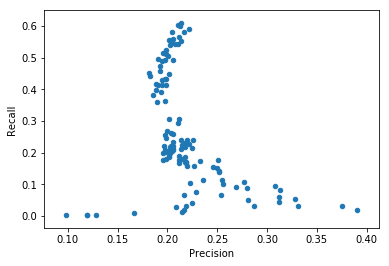

In [67]:
rec_pre.plot.scatter(x = 'Precision',
                    y = 'Recall')
plt.show()

Your plot should look something like this.
![cluster_models](img/precision_v_recall.png)

The baseline, monotone, and interactions models that we were building initially lie in the main clump where precision and recall are approximately 0.2. However, it seems that if you select the parameters appropriately, you will either swing to high recall or high precision.

You can go through all of the parameters (```params```) and their corresponding precision (```mean_test_precision```) and recall scores (```mean_test_recall```) inside ```cv_results_```. Explore the grid search results via the results dictionary and answer the following questions.

1. Which parameter settings are important in order to achieve high recall? Do the settings make sense intuitively?
2. Which parameter settings are important in order to achieve high precision? Do the settings make sense intuitively?

In [ ]:
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': ['auto', 'log2', None],
    'class_weight': ['balanced', None],

In [91]:
# You can write some code to explore the data below
cv_r = pd.DataFrame(optimized_dt.cv_resiults_).drop('params')
cv_r = cv_r.concat(pd.DataFrame(pd.DataFrame(optimized_dt.cv_results_).params)['params'].apply(pd.Series), axis = 1)


AttributeError: 'GridSearchCV' object has no attribute 'cv_resiults_'

In the code below, we've picked out a few parameter settings that either achieve high precision, recall, or a good trade-off between the two, and tested the models on the validation set.

In [18]:
X_train_scaled, X_val_scaled = new_features_and_normalize(X_train, X_val)

best_params = [
    {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'auto', 
     'min_samples_leaf': 20, 'splitter': 'random'},
    {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 
     'min_samples_leaf': 20, 'splitter': 'random'},
    {'class_weight': None, 'criterion': 'entropy', 'max_features': None, 
     'min_samples_leaf': 20, 'splitter': 'random'},
    {'class_weight': None, 'criterion': 'gini', 'max_features': None, 
     'min_samples_leaf': 20, 'splitter': 'random'}
]

for i, param in enumerate(best_params):
    mdl = DecisionTreeClassifier(random_state=1, **param)
    
    precision, recall = fit_and_score_model(mdl, 
                                            X_train_scaled, 
                                            X_val_scaled, 
                                            y_train, 
                                            y_val)
    all_models['best_params_{}'.format(i)] = (precision, recall, mdl, 'run new_features_and_normalize()')

On the validation set, the precision is 0.2461734693877551 and recall is 0.5975232198142415
On the validation set, the precision is 0.23623011015911874 and recall is 0.5975232198142415
On the validation set, the precision is 0.6666666666666666 and recall is 0.01238390092879257
On the validation set, the precision is 0.47619047619047616 and recall is 0.030959752321981424


At this point, it might be useful to review the ```all_models``` dictionary. Write some code to print out the names, precision, recall, (and notes) for all of hte models. Think about your application. Which models are useful? Are there certain models that are definitively better than others? 

In [19]:
for mdl in all_models:
    pre = np.round(all_models[mdl][0], 2)
    rec = np.round(all_models[mdl][1], 2)
    print('{}:\t precision {},\t recall {},\t\t {}'.format(mdl, pre, rec, all_models[mdl][3]))

baseline:	 precision 0.25,	 recall 0.25,		 runs on X_train
monotone:	 precision 0.27,	 recall 0.27,		 run monotone_transform()
interactions:	 precision 0.28,	 recall 0.3,		 run new_feature_combos()
normalized:	 precision 0.28,	 recall 0.3,		 run new_features_and_normalize()
best_params_0:	 precision 0.25,	 recall 0.6,		 run new_features_and_normalize()
best_params_1:	 precision 0.24,	 recall 0.6,		 run new_features_and_normalize()
best_params_2:	 precision 0.67,	 recall 0.01,		 run new_features_and_normalize()
best_params_3:	 precision 0.48,	 recall 0.03,		 run new_features_and_normalize()


## Stacking multiple models

In the previous lab, we studied random forests, which are a type of ensemble model. An ensemble model takes a group of base or simple models, predicts the target with each model, and then uses a voting rule to determine the final prediction. 

Stacked models are similar to ensembles, in the sense that we use a set of (often different) baseline models to predict the target. We then create a new model that takes the base model's predictions as new features in addition to the original ones. The key difference between ensembles and stacking is that instead of a voting rule, we use another prediction model.

Let's create a stacked Logistic Regression model. It will take the original features, in addition to the the predictions of the four decision trees that we found via grid-searching. First, prepare your data. Then, run each of the previous models to predict the target and add each of these new predictions as columns to your training and validation datasets. Then train a new decision tree on the improved dataset.

In [20]:
def stack_models(X, models):
    # This code takes a dataset and a list of pre-trained models, and introduces
    # new features for each of the models.
    stack_features = pd.DataFrame(index=X.index)
    for i, mdl in enumerate(models):
        stack_features['mdl_{}'.format(i)] = mdl.predict(X)
    X = pd.concat([X, stack_features], axis=1)
    
    return X

best_params_models = [ all_models[key][2] for key in all_models.keys() if key.startswith('best_params')]

# First create new features and normalize
X_train_scaled, X_val_scaled = new_features_and_normalize(X_train, X_val)

# Then stack
X_train_grid_search = stack_models(X_train_scaled, best_params_models)
X_val_grid_search = stack_models(X_val_scaled, best_params_models)

# We will use logistic regression instead of a decision tree at the higher-level classifier
mdl_stack = LogisticRegression(random_state=1, penalty='l2', C=0.00001, class_weight='balanced')
precision, recall = fit_and_score_model(mdl_stack, 
                                        X_train_grid_search, 
                                        X_val_grid_search, 
                                        y_train, 
                                        y_val)
all_models['stacked'] = (precision, recall, mdl_stack, 
                         'run new_features_and_normalize(), stack_models(best_params_models)')

On the validation set, the precision is 0.24013528748590757 and recall is 0.6594427244582043


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


When we compared the four grid-searched models in the previous section, we found that some models clearly performed better than others on both precision and recall. However, you might find that if you get rid of one of the models, the performance of the stacked model will decrease. This is because each of the four models are still observing different useful information. Even if the average accuracy of one model is less than another, that model may still be better at predicting for certain subsets and scenarios. 

There are many ways to validate if the base models are different. For example, you could count the number of predicted 1's and 0's for each model. A more detailed analysis would be to see exactly for which cases a certain model correctly predicts 1 over another. In the space below, try exploring the different models.

In [21]:
# Write code here to explore if the base models are different.


Even though the base models are different, they are still all decision trees. Usually when stacking models, it is preferable to use different types of models in your base and different types of models at the top. The intuition is that different model types will learn different characteristics about your data. For example, note that we used a logistic regression at the top. If you go back and try to use a decision tree at the top, you will notice that the performance drops significantly and the top model cannot discern useful information from the base models.

In the end, there are very few hard rules in terms of what you should and shouldn't do when model engineering. Different applications will find different methods work better, and model engineering is effectively an art form rather than a science. You can add new components in the stack, gridsearch to find better parameters of the top model, hunt for new features, train different models on different subsets of data (e.g., bagging/bootstrap), or even train your models on the prediction errors of other models (e.g., boosting). In the space below, feel free to try to improve your model.